# Data Exploration

## Background 

### Data Source
The data used in this notebook is sourced from the National Centers for Environmental Information (NCEI): [Global Historical Climatology Network (GHCN) - Hourly](https://www.ncei.noaa.gov/products/global-historical-climatology-network-hourly). Refer to their documentation and terms of use.


#### Data Set

Station_ID: the station identification code. The first two characters signify the FIPS country code, the third character is a network code identifying the station numbering system used, and the remaining eight characters contain the actual station ID.

Station_Name: the name of the station.

Year: the year the observation was taken in Coordinated Universal Time (UTC).

Month: the month the observation was taken in Coordinated Universal Time (UTC).

Day: the day the observation was taken in Coordinated Universal Time (UTC).

Hour: the hour the observation was taken in Coordinated Universal Time (UTC).

Latitude: latitude of the station (in decimal degrees). North (+); South (-).

Longitude: the longitude of the station (in decimal degrees). East (+); West (-).

Temperature: 2 meter (circa) Above Ground Level Air (dry bulb) Temperature (⁰C to tenths)


Notes: 
- Raw data was removed in download_ghcn.py for storage purposes.
- GHCN hourly dataset contained psv files for individual stations in specific years. When processing the data, it was converted to csv format files for all California stations in years 2003 - 2023.
- Most columns were dropped as they were not needed. Columns kept were described above.
- Duplicate rows that had completely same column values were dropped.

# Data Cleaning

### Set up

In [1]:
import pandas as pd # type: ignore
import sys
import os

# Update paths to get source code from notebook_utils

curr_dir = os.path.dirname(os.path.abspath('notebooks'))
proj_dir = os.path.dirname(curr_dir)
src_path = os.path.join(proj_dir, 'src')
sys.path.append(src_path)

from notebook_utils.preprocessing import combine_files_to_dfs

# create a combined dataframe for all reduced csv files
dfs = combine_files_to_dfs("../data/ghcn_reduced")
CA_stations = pd.concat(dfs, ignore_index=True) # type: ignore

# Create a list of individual dataframes and put them into a list
dataframes = combine_files_to_dfs("../data/ghcn_reduced")

Processed file: reduced_CA_stations_2003.csv
Processed file: reduced_CA_stations_2004.csv
Processed file: reduced_CA_stations_2005.csv
Processed file: reduced_CA_stations_2006.csv
Processed file: reduced_CA_stations_2007.csv
Processed file: reduced_CA_stations_2008.csv
Processed file: reduced_CA_stations_2009.csv
Processed file: reduced_CA_stations_2010.csv
Processed file: reduced_CA_stations_2011.csv
Processed file: reduced_CA_stations_2012.csv
Processed file: reduced_CA_stations_2013.csv
Processed file: reduced_CA_stations_2014.csv
Processed file: reduced_CA_stations_2015.csv
Processed file: reduced_CA_stations_2016.csv
Processed file: reduced_CA_stations_2017.csv
Processed file: reduced_CA_stations_2018.csv
Processed file: reduced_CA_stations_2019.csv
Processed file: reduced_CA_stations_2020.csv
Processed file: reduced_CA_stations_2021.csv
Processed file: reduced_CA_stations_2022.csv
Processed file: reduced_CA_stations_2023.csv
Processed file: reduced_CA_stations_2003.csv
Processed 

### Data Examination

In [2]:
CA_stations.head()

,Station_ID,Station_name,Year,Month,Day,Hour,Latitude,Longitude,temperature
0,USW00023225,BLUE CANYON NYACK AP,2003,1,1,0,39.2761,-120.7092,-1.1
1,USW00023225,BLUE CANYON NYACK AP,2003,1,1,1,39.2761,-120.7092,-1.1
2,USW00023225,BLUE CANYON NYACK AP,2003,1,1,2,39.2761,-120.7092,-1.1
3,USW00023225,BLUE CANYON NYACK AP,2003,1,1,3,39.2761,-120.7092,-1.7
4,USW00023225,BLUE CANYON NYACK AP,2003,1,1,4,39.2761,-120.7092,-2.2


In [3]:
CA_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19851938 entries, 0 to 19851937
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Station_ID    object 
 1   Station_name  object 
 2   Year          int64  
 3   Month         int64  
 4   Day           int64  
 5   Hour          int64  
 6   Latitude      float64
 7   Longitude     float64
 8   temperature   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 1.3+ GB


In [4]:
CA_stations.describe()

,Year,Month,Day,Hour,Latitude,Longitude,temperature
count,1.985194e+07,1.985194e+07,1.985194e+07,1.985194e+07,1.985194e+07,1.985194e+07,1.961237e+07
mean,2.013089e+03,6.504389e+00,1.573293e+01,1.159572e+01,3.668450e+01,-1.201430e+02,1.561475e+01
std,5.375401e+00,3.467041e+00,8.794091e+00,6.939050e+00,2.374357e+00,2.021136e+00,8.620436e+00
min,2.003000e+03,1.000000e+00,1.000000e+00,0.000000e+00,3.256810e+01,-1.242381e+02,-9.900000e+01
25%,2.009000e+03,3.000000e+00,8.000000e+00,6.000000e+00,3.441420e+01,-1.218150e+02,1.050000e+01
50%,2.013000e+03,7.000000e+00,1.600000e+01,1.200000e+01,3.698500e+01,-1.204667e+02,1.470000e+01
75%,2.018000e+03,1.000000e+01,2.300000e+01,1.800000e+01,3.832080e+01,-1.182911e+02,2.000000e+01
max,2.023000e+03,1.200000e+01,3.100000e+01,2.300000e+01,4.178360e+01,-1.161472e+02,9.020000e+02


The temperature column has a really high max celsius value which is 902 degrees celsius. This is unreasonably high. After doing some searching, we found that the highest recorded temperature value was 56.7 degrees celsius in California 1913. 

There is also an unreasonably low temperature observation of -99 degrees celsius since the lowest recorded temperature observation on Earth was -98 degrees in Antartica. 

In [5]:
# Checking which columns have missing data
cols_missing_data = CA_stations.isnull().any()
print(cols_missing_data)

Station_ID      False
Station_name    False
Year            False
Month           False
Day             False
Hour            False
Latitude        False
Longitude       False
temperature      True
dtype: bool


While temperature is the only column with NA cells, there are some completely missing rows meaning not all hours from each year were observed. 

# Cleaning Invalid Data

- Handle Missing Values  (e.g., mean/median impuation, interpolation, forward or backward fill, k-nearest neighbors imputation, deletion)
- Handle Outliers  (e.g., visual inspection by boxplots, Z-score and IQR method, or data transformation by log transformation and winsorization)
- Handle inconsistencies (e.g., checking ranges to ensure temperature values fall within a reasonable range, unit consistency, string matching and standardization), and duplicates (identify and remove duplicates) in the dataset

Notes:
- For non-leap years, there should be 8760 rows (for each hour) for each station.
- For leap years, there should be 8784 rows (for each hour) for each station
- Leap years from 2003-2023 include: 2004, 2008, 2012, 2016, and 2020
- The reduced files contain 99 CA stations.
- Some stations are not observed each year from 2003-2023.


## Handling Inconsistencies

1. Ensure temperature observations are within -50°C and 60°C
2. Temperature values above the reasonable range will be converted to NaN.

In [6]:
# Check how many rows are below -50 and above 60 degrees celsius
CA_stations[(CA_stations['temperature'] < -50) | (CA_stations['temperature'] > 60)]


,Station_ID,Station_name,Year,Month,Day,Hour,Latitude,Longitude,temperature
1439248,USW00093104,CHINA LAKE NAF,2005,3,21,12,35.6864,-117.6908,80.3
1440726,USW00093104,CHINA LAKE NAF,2005,5,20,2,35.6864,-117.6908,83.0
1448841,USW00093107,SAN DIEGO MIRAMAR NAS,2005,3,16,11,32.8667,-117.1333,78.0
1457459,USW00093107,SAN DIEGO MIRAMAR NAS,2005,9,23,2,32.8667,-117.1333,-78.0
1458755,USW00093107,SAN DIEGO MIRAMAR NAS,2005,10,21,22,32.8667,-117.1333,78.0
...,...,...,...,...,...,...,...,...,...
19654066,USW00023289,PALO ALTO,2023,2,8,17,37.4667,-122.1167,80.0
19772424,USW00093193,FRESNO YOSEMITE INTL,2023,5,15,16,36.7800,-119.7203,227.0
19781493,USW00093201,TRUCKEE AP,2023,5,23,15,39.3200,-120.1394,70.0
19829035,USW00093231,SAN CARLOS AP,2023,2,10,15,37.5167,-122.2500,70.0


In [ ]:
# Write code to turn temperature outside of the specified range into NaN

## Handling Missing Values

### Filling missing rows

In [7]:
from notebook_utils.preprocessing import create_full_df

# create a reference dataframe with all stations with hours from 2003 to 2023
full_df = create_full_df()

99


In [8]:
from notebook_utils.preprocessing import process_by_year

# Compare reference dataframe and CA_stations dataframe to figure out which rows of data are completely missing
CA_stations = process_by_year(full_df, CA_stations) # dataframe with added rows

#CA_stations.to_csv('filled_data.csv') # Uncomment to get a csv file from the new dataframe

c:\Users\lizbe\Downloads\PHIT 2024\projs\PHIT-Project-1\src\notebook_utils\preprocessing.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... 'ALTURAS MUNI AP' 'ALTURAS MUNI AP' 'ALTURAS MUNI AP']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  missing_rows.loc[missing_name_mask, 'Station_name'] = missing_rows.loc[missing_name_mask, 'Station_ID'].map(


In [9]:
CA_stations.head()

,Station_ID,Station_name,Year,Month,Day,Hour,Latitude,Longitude,temperature
0,USW00023222,NaN,2003,1,1,0,NaN,NaN,NaN
1,USW00023222,NaN,2003,1,1,1,NaN,NaN,NaN
2,USW00023222,NaN,2003,1,1,2,NaN,NaN,NaN
3,USW00023222,NaN,2003,1,1,3,NaN,NaN,NaN
4,USW00023222,NaN,2003,1,1,4,NaN,NaN,NaN


### Station Deletion

Stations with no Station_name values will be dropped as that means there are no observations recorded for them at all from 2003 - 2023

In [10]:
CA_stations.dropna(subset=['Station_name'], inplace=True)   # 21 stations dropped
#CA_stations.to_csv('updated_rows_data.csv')

### Row Deletion

In [11]:
CA_stations.iloc[[9651,9652,9653,9654,9655]]

,Station_ID,Station_name,Year,Month,Day,Hour,Latitude,Longitude,temperature
18411,USW00023224,AUBURN MUNI AP,2004,6,15,17,38.9547,-121.0819,28.0
18412,USW00023224,AUBURN MUNI AP,2004,6,15,17,38.9547,-121.0819,29.0
18413,USW00023224,AUBURN MUNI AP,2004,6,15,18,38.9547,-121.0819,30.0
18414,USW00023224,AUBURN MUNI AP,2004,6,15,19,38.9547,-121.0819,31.0
18415,USW00023224,AUBURN MUNI AP,2004,6,15,19,38.9547,-121.0819,32.0


There are rows with the same value in each column except temperature. In these cases we will average out the temperature observations and delete the extra rows.

In [12]:
grouped_df = CA_stations.groupby(['Station_ID', 'Station_name', 'Year', 'Month', 'Day', 'Hour', 'Latitude', 'Longitude']).agg({'temperature': 'mean'}).reset_index()

In [13]:
CA_stations = grouped_df
CA_stations.iloc[[9251,9252,9253,9254]]

,Station_ID,Station_name,Year,Month,Day,Hour,Latitude,Longitude,temperature
9251,USW00023224,AUBURN MUNI AP,2004,6,15,17,38.9547,-121.0819,28.5
9252,USW00023224,AUBURN MUNI AP,2004,6,15,18,38.9547,-121.0819,30.0
9253,USW00023224,AUBURN MUNI AP,2004,6,15,19,38.9547,-121.0819,31.5
9254,USW00023224,AUBURN MUNI AP,2004,6,15,20,38.9547,-121.0819,32.5


## Filling missing temperature values

In [14]:
null_count = CA_stations.isna().sum()
null_percent = (null_count/CA_stations.shape[0]) * 100
print(f'Percentage of null values for each column: \n{null_percent}')

Percentage of null values for each column: 
Station_ID      0.000000
Station_name    0.000000
Year            0.000000
Month           0.000000
Day             0.000000
Hour            0.000000
Latitude        0.000000
Longitude       0.000000
temperature     3.247565
dtype: float64


### Missing Temperature Values: Handling short gaps in temperature observations

We define a "short gap" as being a gap in the temperature column that is less than a day. 

Short gaps in temperature observations will be handled with forward/backward fill.

### Missing Temperature Values: Handling large gaps in temperature observations

We define a "large gap" as being a gap in the temperature column that is more than a day.

Large gaps in temperature observations will be handled via interpolation

#### Cubic Spline Interpolation for large gaps of missing temperature values

In [15]:
from notebook_utils.preprocessing import cubic_spline_interpolate

CA_interpolated_df = cubic_spline_interpolate(CA_stations,gap_hours=24)


In [16]:
CA_interpolated_df.head()

,Station_ID,Station_name,Year,Month,Day,Hour,Latitude,Longitude,temperature
0,USW00023224,AUBURN MUNI AP,2003,1,1,0,38.9547,-121.0819,11.0
85,USW00023224,AUBURN MUNI AP,2003,1,1,1,38.9547,-121.0819,9.9
189,USW00023224,AUBURN MUNI AP,2003,1,1,2,38.9547,-121.0819,8.8
311,USW00023224,AUBURN MUNI AP,2003,1,1,3,38.9547,-121.0819,8.1
368,USW00023224,AUBURN MUNI AP,2003,1,1,4,38.9547,-121.0819,7.4


In [17]:
CA_interpolated_df.isna().any()

Station_ID      False
Station_name    False
Year            False
Month           False
Day             False
Hour            False
Latitude        False
Longitude       False
temperature     False
dtype: bool

#### Validation

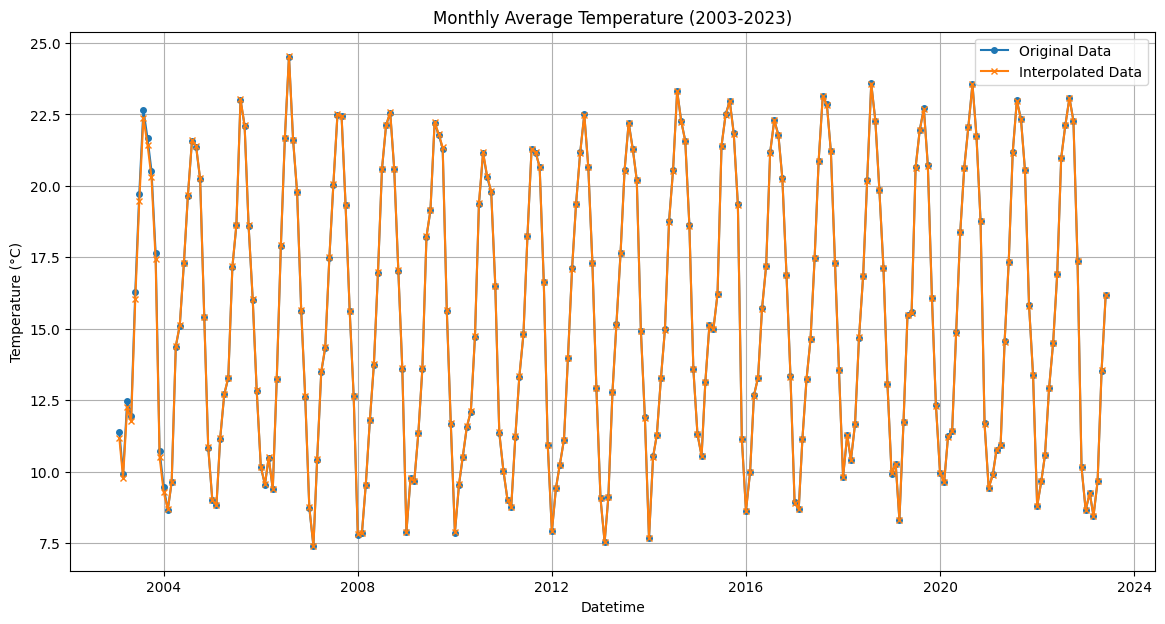

In [18]:
import matplotlib.pyplot as plt

# make copies to not alter original dataframes
plot_CA_stations = CA_stations.copy()
plot_CA_interpolated = CA_interpolated_df.copy()

plot_CA_stations['Datetime'] = pd.to_datetime(plot_CA_stations[['Year', 'Month', 'Day', 'Hour']])
plot_CA_interpolated['Datetime'] = pd.to_datetime(plot_CA_interpolated[['Year', 'Month', 'Day', 'Hour']])

plot_CA_stations.set_index('Datetime', inplace=True)
plot_CA_interpolated.set_index('Datetime', inplace=True)

monthly_avg_original = plot_CA_stations['temperature'].resample('ME').mean()
monthly_avg_interpolated = plot_CA_interpolated['temperature'].resample('ME').mean()

plt.figure(figsize=(14, 7))

plt.plot(monthly_avg_original.index, monthly_avg_original.values, 'o-', label='Original Data', markersize=4)

plt.plot(monthly_avg_interpolated.index, monthly_avg_interpolated.values, 'x-', label='Interpolated Data', markersize=4)

plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Monthly Average Temperature (2003-2023)')
plt.legend()
plt.grid(True)
plt.show()

## Handling Outliers

Outliers can skew our statistical analysis of the data. 

### 1. Visual Inspection

#### Boxplot

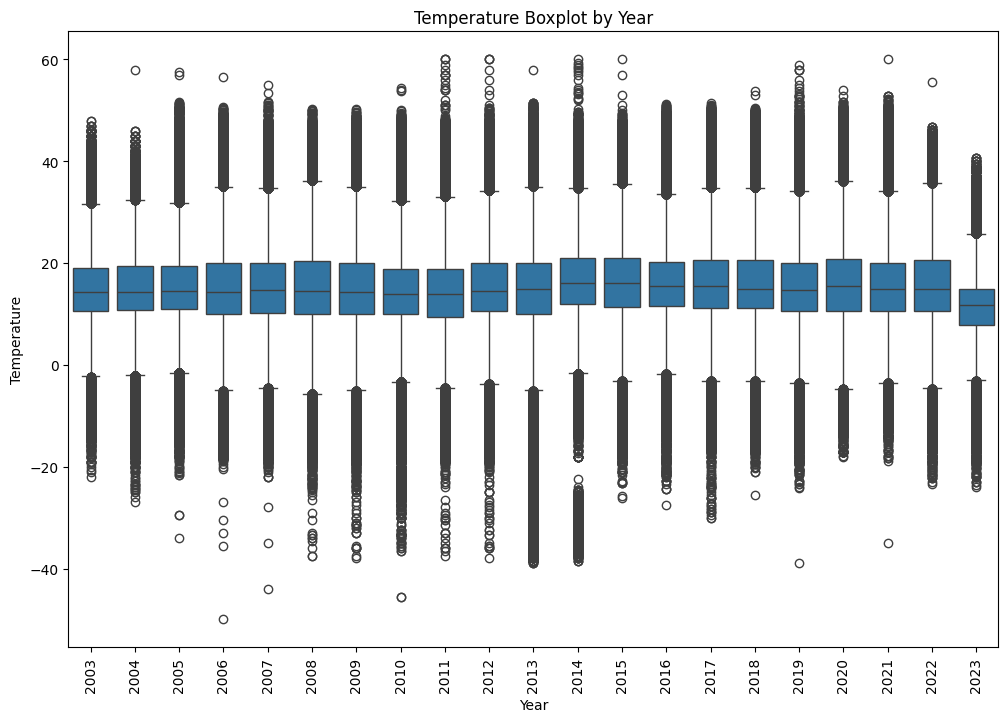

In [35]:
filtered_CA_stations = CA_interpolated_df[(CA_interpolated_df['temperature'] >= -50) & (CA_interpolated_df['temperature'] <= 60)]
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x='Year', y='temperature', data=filtered_CA_stations)
plt.title('Temperature Boxplot by Year')
plt.xticks(rotation=90)  
plt.ylabel('Temperature')
plt.show()

### 2. Statistical Methods

#### Z-Score

In [30]:
from scipy import stats

z_stations = CA_interpolated_df.copy()
z_stations['Z_score'] = stats.zscore(z_stations['temperature'])
z_thresh = 3

# Calcualate outliers using Z-score
z_outliers = z_stations[(z_stations['Z_score'] < -z_thresh) | (z_stations['Z_score'] > z_thresh)]
z_outliers.shape[0]

71079

#### Interquartile Range (IQR)

Calculate IQR

In [25]:
quartile_1 = CA_interpolated_df['temperature'].quantile(0.25)
quartile_3 = CA_interpolated_df['temperature'].quantile(0.75)

# calculate IQR
IQR = quartile_3 - quartile_1
print(IQR)

9.4


Calculate Outlier Thresholds

In [26]:
lower = (quartile_1 - 1.5*IQR).round(1)
upper = quartile_3 + 1.5*IQR

print(f'Outlier threshold lower bound is: {lower}\nOutlier threshold upper bound is: {upper}')

Outlier threshold lower bound is: -3.5
Outlier threshold upper bound is: 34.1


Count outliers in dataframe

In [34]:
outliers = CA_interpolated_df[(CA_interpolated_df['temperature'] < lower) | (CA_interpolated_df['temperature'] > upper)]
outliers.shape[0]

365685

### 3. Data Transformation

#### Log Transformation or Winsorization